In [3]:
!pip install statsmodels
!pip install scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 9.8 MB/s eta 0:00:00:00:010:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.9/232.9 kB 9.0 MB/s eta 0:00:00

[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: pip install --upgrade pip
  Using cached joblib-1.5.2-py3-none-any.whl.metadata (5.6 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 10.7 MB/s eta 0:00:0000:0100:01
Using cached joblib-1.5.2-py3-none-any.whl (308 kB)
Using cached threadpoolctl-3.6.0-py3-none-any.whl (18 kB)

[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [4]:
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import numpy as np

from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [5]:
# Ignorar warnings
warnings.filterwarnings('ignore')

In [11]:
# Cargar el dataframe
df = pd.read_csv('../data/processed/complete_merged.csv')

In [12]:
df.shape

(696, 79)

In [13]:
df.isnull().sum()

Country                                                 0
Year                                                    0
Agricultural production index (2014-2016=100)         102
Balance of payments, current account (million US$)    134
CPI: Consumer Price Index (2010=100)                  110
                                                     ... 
Region                                                  0
Sex ratio (m per 100 f)                                 6
Surface area (km2)                                     18
UN membership date                                    117
Capital_city_pop                                        3
Length: 79, dtype: int64

In [14]:
# ===== PREPROCESAMIENTO SEGÚN TUS COLUMNAS =====
df = df.copy()

# --- 1) Esperanza de vida "global" (promedio F y M)
col_life_f = "Life expectancy at birth - Female (years)"
col_life_m = "Life expectancy at birth - Male (years)"
df["EsperanzaVida"] = df[[col_life_f, col_life_m]].mean(axis=1)

# --- 2) Escolarización (promedio F y M)
# Primaria
col_prim_f = "Education: Primary gross enrol. ratio - Female (per 100 pop.)"
col_prim_m = "Education: Primary gross enrol. ratio - Male (per 100 pop.)"
df["Escolarizacion_Primaria"] = df[[col_prim_f, col_prim_m]].mean(axis=1)

# Secundaria (tomaremos Upper Secondary como proxy de secundaria)
col_upsec_f = "Education: Upper Sec. gross enrol. ratio - Female (per 100 pop.)"
col_upsec_m = "Education: Upper Sec. gross enrol. ratio - Male (per 100 pop.)"
df["Escolarizacion_Secundaria"] = df[[col_upsec_f, col_upsec_m]].mean(axis=1)

# --- 3) Gasto en salud % PIB
df["GastoSalud_PIB"] = df["Health: Current expenditure (% of GDP)"]

# --- 4) Fertilidad
df["TasaFertilidad"] = df["Fertility rate, total (live births per woman)"]

# --- 5) Desarrollo (numérico proxy = PIB per cápita; categórico = cuartil superior vs resto)
df["IndiceDesarrollo"] = df["GDP per capita (current US$)"]

# Umbral de "Desarrollado": top 25% por PIB per cápita 
cutoff = df["IndiceDesarrollo"].quantile(0.75)
df["NivelDesarrollo"] = np.where(df["IndiceDesarrollo"] >= cutoff, "Desarrollado", "En desarrollo")

# --- 6) Médicos y Mortalidad (usaremos mortalidad <5 años como proxy de mortalidad)
df["Medicos_x1000"] = df["Health: Physicians (per 1 000 pop.)"]
df["TasaMortalidad"] = df["Under five mortality rate (per 1000 live births)"]

print("Dimensiones:", df.shape)
df[["Country","Year","EsperanzaVida","Escolarizacion_Primaria","Escolarizacion_Secundaria",
    "GastoSalud_PIB","TasaFertilidad","IndiceDesarrollo","NivelDesarrollo","Medicos_x1000","TasaMortalidad"]].head(5)


Dimensiones: (696, 88)


,Country,Year,EsperanzaVida,Escolarizacion_Primaria,Escolarizacion_Secundaria,GastoSalud_PIB,TasaFertilidad,IndiceDesarrollo,NivelDesarrollo,Medicos_x1000,TasaMortalidad
0,Afghanistan,2015.0,62.30,105.65,41.1,10.1,5.7,554.0,En desarrollo,0.3,76.5
1,Afghanistan,2020.0,61.60,109.45,41.7,15.5,5.1,512.7,En desarrollo,0.3,62.9
2,Afghanistan,2024.0,66.25,NaN,NaN,21.8,4.8,344.6,En desarrollo,NaN,54.5
3,Albania,2015.0,78.40,113.25,98.4,6.5,1.6,3950.4,En desarrollo,1.3,10.1
4,Albania,2020.0,77.85,100.60,93.3,7.5,1.4,5289.0,En desarrollo,1.9,9.4


In [15]:
# ===== MAPEO DE COLUMNAS PARA EL GUION DE HIPÓTESIS =====
COL = {
    "health_exp_gdp": "GastoSalud_PIB",             # % PIB en salud (derivada)
    "life_expect": "EsperanzaVida",                 # años (promedio F y M)
    "fertility": "TasaFertilidad",                  # hijos por mujer
    "school_primary": "Escolarizacion_Primaria",    # % (promedio F y M)
    "school_secondary": "Escolarizacion_Secundaria",# % (Upper Sec promedio F y M)
    "dev_status": "NivelDesarrollo",                # categórica: "Desarrollado"/"En desarrollo" (cuartil superior por PIB pc)
    "dev_index": "IndiceDesarrollo",                # numérica: PIB per cápita (proxy de desarrollo)
    "physicians": "Medicos_x1000",                  # médicos por 1,000 hab
    "mortality": "TasaMortalidad"                   # proxy: mortalidad <5 (por 1,000 nacidos vivos)
}


**Pregunta:** ¿Los países con mayor gasto en salud (% del PIB) tienen una esperanza de vida diferente a los países con menor gasto en salud?

$H_0$: La media de la esperanza de vida en países con alto gasto en salud es igual a la media en países con bajo gasto en salud.

$H_1$: La media de la esperanza de vida en países con alto gasto en salud es distinta a la media en países con bajo gasto en salud.

In [20]:
# Dividir países en alto vs bajo gasto en salud
umbral = df[COL["health_exp_gdp"]].median()
grupo_alto = df[df[COL["health_exp_gdp"]] >= umbral][COL["life_expect"]].dropna()
grupo_bajo = df[df[COL["health_exp_gdp"]] < umbral][COL["life_expect"]].dropna()

# Prueba t-test (Welch)
t, p = stats.ttest_ind(grupo_alto, grupo_bajo, equal_var=False)

print("Hipótesis 1: Gasto en salud vs Esperanza de vida")
print(f"Media (alto)={grupo_alto.mean():.2f}, Media (bajo)={grupo_bajo.mean():.2f}")
print(f"t={t:.4f}, p={p:.4g}")
print("Decisión (α=0.05):", "Rechazo H0" if p < 0.05 else "No rechazo H0")


Hipótesis 1: Gasto en salud vs Esperanza de vida
Media (alto)=74.54, Media (bajo)=69.84
t=7.8641, p=1.896e-14
Decisión (α=0.05): Rechazo H0


**Pregunta:** ¿La tasa de fertilidad influye en la esperanza de vida de los países?

$H_0$: La media de la esperanza de vida es igual en países con alta tasa de fertilidad y en países con baja tasa de fertilidad.

$H_1$: La media de la esperanza de vida en países con alto gasto en salud es distinta a la media en países con bajo gasto en salud.

In [21]:
umbral = df[COL["fertility"]].median()
grupo_alta = df[df[COL["fertility"]] >= umbral][COL["life_expect"]].dropna()
grupo_baja = df[df[COL["fertility"]] < umbral][COL["life_expect"]].dropna()

# Prueba t-test (Welch)
t, p = stats.ttest_ind(grupo_alta, grupo_baja, equal_var=False)

print("Hipótesis 2: Fertilidad vs Esperanza de vida")
print(f"Media (alta fertilidad)={grupo_alta.mean():.2f}, Media (baja fertilidad)={grupo_baja.mean():.2f}")
print(f"t={t:.4f}, p={p:.4g}")
print("Decisión (α=0.05):", "Rechazo H0" if p < 0.05 else "No rechazo H0")

Hipótesis 2: Fertilidad vs Esperanza de vida
Media (alta fertilidad)=68.32, Media (baja fertilidad)=78.03
t=-22.6859, p=1.644e-81
Decisión (α=0.05): Rechazo H0


**Pregunta:** ¿Existen diferencias en las tasas de escolarización (primaria y secundaria) entre países desarrollados y países en desarrollo?

$H_0$: La media de las tasas de escolarización en países desarrollados es igual a la de los países en desarrollo.

$H_1$: La media de las tasas de escolarización en países desarrollados es mayor que la de los países en desarrollo

In [23]:
# Grupos por nivel de desarrollo
grupo_des = df[df[COL["dev_status"]] == "Desarrollado"][COL["school_primary"]].dropna()
grupo_no_des = df[df[COL["dev_status"]] == "En desarrollo"][COL["school_primary"]].dropna()

# Prueba t-test (Welch)
t, p = stats.ttest_ind(grupo_des, grupo_no_des, equal_var=False)

print("Hipótesis 3: Escolarización (primaria) vs Nivel de desarrollo")
print(f"Media (desarrollado)={grupo_des.mean():.2f}, Media (en desarrollo)={grupo_no_des.mean():.2f}")
print(f"t={t:.4f}, p={p:.4g}")
print("Decisión (α=0.05):", "Rechazo H0" if p < 0.05 else "Acepta H0")

# --- Repetimos para escolarización secundaria ---
grupo_des_sec = df[df[COL["dev_status"]] == "Desarrollado"][COL["school_secondary"]].dropna()
grupo_no_des_sec = df[df[COL["dev_status"]] == "En desarrollo"][COL["school_secondary"]].dropna()

t2, p2 = stats.ttest_ind(grupo_des_sec, grupo_no_des_sec, equal_var=False)

print("\nHipótesis 3: Escolarización (secundaria) vs Nivel de desarrollo")
print(f"Media (desarrollado)={grupo_des_sec.mean():.2f}, Media (en desarrollo)={grupo_no_des_sec.mean():.2f}")
print(f"t={t2:.4f}, p={p2:.4g}")
print("Decisión (α=0.05):", "Rechazo H0" if p2 < 0.05 else "Acepta H0")

Hipótesis 3: Escolarización (primaria) vs Nivel de desarrollo
Media (desarrollado)=101.09, Media (en desarrollo)=101.37
t=-0.2806, p=0.7792
Decisión (α=0.05): Acepta H0

Hipótesis 3: Escolarización (secundaria) vs Nivel de desarrollo
Media (desarrollado)=114.20, Media (en desarrollo)=71.01
t=14.5277, p=4.094e-35
Decisión (α=0.05): Rechazo H0


**Pregunta:** ¿El gasto en salud (% del PIB) está asociado con el nivel de desarrollo de los países?

$H_0$: La media del PIB per cápita es igual en países con alto y bajo gasto en salud.

$H_1$: La media del PIB per cápita es mayor en países con alto gasto en salud que en países con bajo gasto en salud.

In [24]:
# Dividir países en alto vs bajo gasto en salud (mediana)
umbral = df[COL["health_exp_gdp"]].median()
alto = df[df[COL["health_exp_gdp"]] >= umbral][COL["dev_index"]].dropna()
bajo = df[df[COL["health_exp_gdp"]] <  umbral][COL["dev_index"]].dropna()

# Prueba t-test (Welch)
t, p = stats.ttest_ind(alto, bajo, equal_var=False)

print("Hipótesis 4: Gasto en salud (alto vs bajo) → PIB per cápita (desarrollo)")
print(f"Media (alto)={alto.mean():.2f}, Media (bajo)={bajo.mean():.2f}")
print(f"t={t:.4f}, p={p:.4g}")
print("Decisión (α=0.05):", "Rechazo H0" if p < 0.05 and alto.mean() > bajo.mean() else "Acepta H0")

Hipótesis 4: Gasto en salud (alto vs bajo) → PIB per cápita (desarrollo)
Media (alto)=19019.34, Media (bajo)=11300.35
t=3.8477, p=0.0001339
Decisión (α=0.05): Rechazo H0


**Pregunta:** ¿El número de médicos por cada 1,000 habitantes influye en la tasa de mortalidad de los países?

$H_0$: La media de la tasa de mortalidad es igual en países con muchos médicos y en países con pocos médicos.

$H_1$: La media de la tasa de mortalidad es menor en países con muchos médicos que en países con pocos médicos.

In [25]:
umbral = df[COL["physicians"]].median()
muchos = df[df[COL["physicians"]] >= umbral][COL["mortality"]].dropna()
pocos = df[df[COL["physicians"]] <  umbral][COL["mortality"]].dropna()

# Prueba t-test (Welch)
t, p = stats.ttest_ind(muchos, pocos, equal_var=False)

print("Hipótesis 5: Médicos (muchos vs pocos) → Tasa de mortalidad")
print(f"Media (muchos)={muchos.mean():.2f}, Media (pocos)={pocos.mean():.2f}")
print(f"t={t:.4f}, p={p:.4g}")
print("Decisión (α=0.05):", "Rechazo H0" if p < 0.05 and muchos.mean() < pocos.mean() else "No rechazo H0")

Hipótesis 5: Médicos (muchos vs pocos) → Tasa de mortalidad
Media (muchos)=8.58, Media (pocos)=47.17
t=-18.8787, p=9.249e-51
Decisión (α=0.05): Rechazo H0


In [26]:
    
vars_pca = [
    COL["health_exp_gdp"],
    COL["fertility"],
    COL["life_expect"],
    COL["school_primary"],
    COL["school_secondary"],
    COL["physicians"],
    COL["dev_index"]
]


df_pca = df[vars_pca].dropna()

In [ ]:
# Estandarizar los datos de df_pca
scaler = StandardScaler()
X_std = scaler.fit_transform(df_pca)

print("Antes de estandarizar (primeras filas):")
display(df_pca.head())

print("\nDespués de estandarizar (primeras filas):")
print(X_std[:5])

print(f"\nForma de los datos estandarizados: {X_std.shape}")
print(f"Media de cada variable estandarizada: {X_std.mean(axis=0).round(3)}")
print(f"Desviación estándar de cada variable estandarizada: {X_std.std(axis=0).round(3)}")


ValueError: could not convert string to float: 'Year'

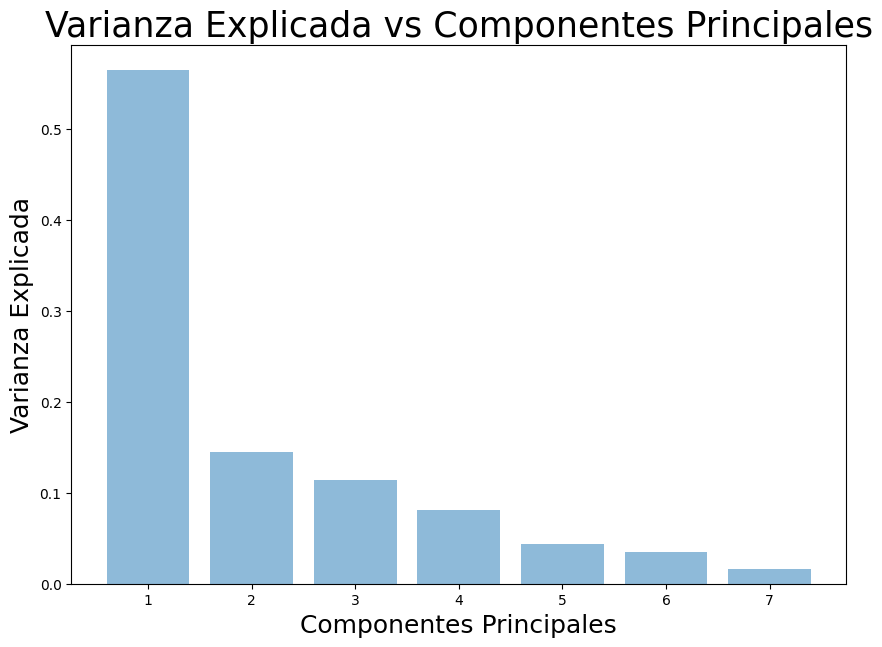

In [35]:
pca = PCA(None)
X_pca = pca.fit_transform(X_std)
var_exp = pca.explained_variance_ratio_


background_color = "#ffffff"
fig = plt.figure(figsize=(10,7), facecolor=background_color)
plt.bar(range(1, len(var_exp)+1), var_exp, alpha=0.5, align='center')
plt.ylabel('Varianza Explicada',  fontsize = 18)
plt.xlabel('Componentes Principales', fontsize = 18)
plt.title('Varianza Explicada vs Componentes Principales', fontsize = 25)
plt.show()